# Тема 13. Изменение изображений.
На прошлых занятиях мы генерировали, то есть создавали, изображения с нуля, задавая латентные переменные и шум. Но бывает так, что нужно изменить уже существующее изображение, обработать его.

Мы умеем делать простые обработки - изменение размера, повороты, изменение цвета и т.п. Но если хотим делать более сложные обработки, например перерисовать фотографию так, как будто это мультяшное изображение, то нужны более сложные методы. 

Генеративно-состязательный подход может помочь и в этом случае, но потребуется внести изменения в генератор и дискриминатор.





# CartoonGAN 

Посмотрим, как это работает на примере CartoonGAN - сети для перевода изображений в мультяшный вид.

В такой задаче важно сохранить содержание изображения (что на нем нарисовано), но переделать стиль рисования (как это нарисовано). Для этого вводятся две функции ошибки: **ошибка генерации** и **ошибка содержания**. Общая ошибка, которая будет минимизироваться, состоит из этих двух с некоторым коэффициентом, который показывает, какая из них важней.

![img](https://drive.google.com/uc?id=1HWRu51qBBJGXvVFs1D-Dd-wbgiuVFhUN)







## Ошибка генерации 
Ошибка генерации показывает, насколько сгенерированное изображение похоже на мультяшное. Чтобы это понять используют набор изображений из мультиков. Как выяснилось, главное отличие изображений в мультиках от настоящих - это четко прорисованные контуры. Дискриминатор обучится, что если есть четкие контуры, то это мультяшное изображение и генератор легко его обманет делая бессмысленные картинки, но с четкими контурами. Чтобы это предотвратить на мультяшных изображениях обнаруживают контуры и принудительно размывают их.

Дискриминатор будет работать с *тремя* наборами картинок:
- настоящими мультяшными - их надо определить как подходящие.
- настоящими мультяшными, но с размытыми контурами - их надо определить как неподходящие (сгенерированные).
- созданные генератором - их надо определить как неподходящие. 

Ошибка генерации считается на этих трех наборах изображений.

Для упрощения работы дискриминатор будет работать не со всей картинкой целиком, а с ее небольшими частями (патчи), тогда его можно сделать гораздо проще (а значит и быстрее).

## Ошибка содержания

Ошибка содержания показывает, насколько сгенерированное (обработанное) изображение отличается от исходного.

На вход генератора поступает исходное изображение, которое мы хотим перерисовать (это замена латентным переменным), а на выходе генератора получается созданное (сгенерированное) изображение такого же размера.

Чтобы сравнить два изображения используется такой же подход, какой мы видели в предыдущей теме по переносу стиля изображения - берут предобученную сеть (здесь VGG) и сравнивают выходы промежуточных сверточных слоев (карты признаков) для одного и другого изображений. 

Для улучшения работы генератора, перед началом работы его инициализируют, обучая несколько эпох только на этой ошибке содержания, а затем уже подключают и ошибку генерации.  

   

# Предобученная сеть CartoonGAN-TensorFlow2

Хоть сети, которые используются для генератора и дискриминатора не очень большие, все равно время обучения велико для работы на уроке (несколько часов на графическом процессоре), поэтому мы воспользуемся уже обученными сетями для обработки своих изображений. Но если вам интересно и есть возможность, то можете обучать такую сеть сами, коды для этого находятся в той же библиотеке [CartoonGan](https://github.com/mnicnc404/CartoonGan-tensorflow).

Для универсальности, работа с библиотекой выполняется через командную строку, запуская уже готовые программы, поэтому это можно использовать на любом компьютере с Python и необходимыми библиотеками (tensorflow и др.).

То же самое можно сделать через сайт 
https://leemeng.tw/generate-anime-using-cartoongan-and-tensorflow2-en.html

### Клонируем содержимое библиотеки
В ней есть и уже обученные сети.

In [ ]:
import os #
repo = "CartoonGan-tensorflow" # название
# клонируем
!git clone https://github.com/mnicnc404/{repo}.git 
os.chdir(os.path.join(repo)) # добавляем путь к ней и назначаем его текущим

Cloning into 'CartoonGan-tensorflow'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 1584 (delta 3), reused 5 (delta 2), pack-reused 1577
Receiving objects: 100% (1584/1584), 345.93 MiB | 31.36 MiB/s, done.
Resolving deltas: 100% (688/688), done.
Checking out files: 100% (425/425), done.


In [ ]:
# проверим что есть основной файл
!ls | grep cartoonize.py

cartoonize.py


### Установка других библиотек
Нужен TensorFlow 2.0 (уже есть в Colab) и  [keras-contrib](https://github.com/keras-team/keras-contrib) - расширение библиотеки Keras.

In [ ]:
from IPython.display import clear_output, display, Image # для рисования

In [ ]:
#!pip install tensorflow-gpu==2.0.0-alpha0
!git clone https://www.github.com/keras-team/keras-contrib.git \
    && cd keras-contrib \
    && python convert_to_tf_keras.py \
    && USE_TF_KERAS=1 python setup.py install
clear_output()

In [ ]:
import tensorflow as tf # подключаем
tf.__version__ # проверим версию

'2.4.1'

### Загрузка исходных изображений
Укажите URL изображений, которые хотите перерисовать. 

Поддерживаются форматы:
- `.jpg`
- `.png`
- `.gif`

Как пример:
- Harry Potter: https://media.giphy.com/media/o5HKScC1PflLO/giphy.gif
- Iron man: https://media.giphy.com/media/rlsHtd2YC8k0g/giphy.gif

In [ ]:
# URL исходного изображения
image_url = 'https://media.giphy.com/media/rlsHtd2YC8k0g/giphy.gif'  #

Скачиваем и сохраняем изображение, оно должно попасть в input_images директорию. А результат обработки окажется в output_images.

In [ ]:
input_image_dir = "input_images" # директория с исходными изображениями
output_image_dir = input_image_dir.replace("input_", "output_") # директория с результатом.

import time
if image_url:
    img_filename = image_url.split("/")[-1] # полное название файла извлекаем из URL (это последняя часть строки после знака /)
    name, ext = '.'.join(img_filename.split(".")[:-1]), img_filename.split(".")[-1] # разбиваем на название и расширение файла
    new_name = '_'.join((name, str(int(time.time())))) # чтобы было уникальное имя файла, добавим ему текущее время
    new_img_filename = '.'.join((new_name, ext)) # и добавим расширение файла
    image_path = os.path.join(input_image_dir, new_img_filename) # путь к файлу
    
    # скачиваем файл, переименовываем его, и перемещаем в input_images директорию
    !wget {image_url} \
        && mv {img_filename} {new_img_filename} \
        && mv {new_img_filename} {image_path}

--2021-03-01 10:15:46--  https://media.giphy.com/media/rlsHtd2YC8k0g/giphy.gif
Resolving media.giphy.com (media.giphy.com)... 151.101.38.2
Connecting to media.giphy.com (media.giphy.com)|151.101.38.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 458425 (448K) [image/gif]
Saving to: ‘giphy.gif’

giphy.gif           100%[===================>] 447.68K  --.-KB/s    in 0.02s   

2021-03-01 10:15:46 (22.9 MB/s) - ‘giphy.gif’ saved [458425/458425]



Посмотрим, что мы загрузили:

In [ ]:
# сменим расширение на png  и скоприруем gif в png
if ".gif" in new_img_filename:
    png_path = new_img_filename + '.png'
    !cp {image_path} {png_path}

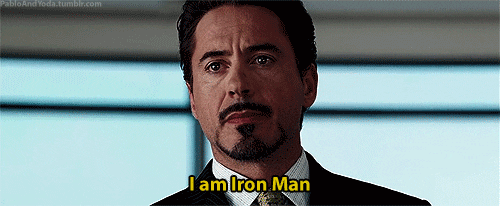

In [ ]:
display(Image(png_path)) # png можно отобразить

## Мультяшное преобразование
Выберем стиль мультика.

In [ ]:
# 
styles = "hayao" #@param ["shinkai", "hayao", "hosoda", "paprika"]

Для обработки выполняем из командной строки скрипт cartoonize.py, которому передаем аргументы:
* --styles - стиль  
* --comparison_view horizontal - способ отображения результата.

О других опциях можно узнать выполнив


In [ ]:
!python cartoonize.py -h

2021-03-01 10:28:21.498363: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
usage: cartoonize.py [-h] [--styles STYLES [STYLES ...]] [--all_styles]
                     [--input_dir INPUT_DIR] [--output_dir OUTPUT_DIR]
                     [--batch_size BATCH_SIZE] [--ignore_gif] [--overwrite]
                     [--skip_comparison]
                     [--comparison_view {smart,horizontal,vertical,grid}]
                     [--gif_frame_frequency GIF_FRAME_FREQUENCY]
                     [--max_num_frames MAX_NUM_FRAMES] [--keep_original_size]
                     [--max_resized_height MAX_RESIZED_HEIGHT]
                     [--convert_gif_to_mp4]
                     [--logging_lvl {debug,info,warning,error,critical}]
                     [--debug] [--show_tf_cpp_log]

transform real world images to specified cartoon style(s)

optional arguments:
  -h, --help            show this help message and exit
  --styles

In [ ]:
# вызываем скрипт обработки
!python cartoonize.py \
    --styles {styles} \
    --comparison_view horizontal

2021-03-01 10:28:54.598903: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
[2021-03-01 10:28:55] [Cartoonizer] [INFO] Transformed images will be saved to `output_images` folder.
2021-03-01 10:28:55.911288: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-03-01 10:28:55.912174: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-03-01 10:28:55.929919: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-03-01 10:28:55.930490: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB d

### Отображение результата
Для gif преобразуем их в png, для остальных просто рисуем, поместив результаты в директорию comparison.  

In [ ]:
if img_filename:
    if ".gif" in img_filename:
        generated_gif = os.path.join(output_image_dir, "comparison", new_img_filename)
        result_path = generated_gif + '.png'
        !cp {generated_gif} {result_path}
    else:
        result_path = os.path.join(output_image_dir, "comparison", new_img_filename)

In [ ]:
display(Image(result_path)) # отображаем

### Сохранение результата

Скачаем результат из Colab.


Если ненужно исходное изображение, то установите  `include_original_image` в `no`.

In [ ]:
include_original_image = "no"  #@param {type: "string"}

In [ ]:
from google.colab import files
if include_original_image == "yes":
    output_image_path = os.path.join(output_image_dir, "comparison", new_img_filename)
else:
    output_image_path = os.path.join(output_image_dir, styles, new_img_filename)
files.download(output_image_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Задания

Преобразуйте другие изображения в мультяшные. Проверьте и сравните разные стили. Обрадуйте учителя рисования, как хорошо вы умеете рисовать.

#Ссылки
Использованы и адаптированы материалы:

https://github.com/mnicnc404/CartoonGan-tensorflow